In [2]:
# -*- coding: utf-8 -*-
"""
Hybrid Pix2Pix SAR-to-RGB Translation in Lab Color Space.

This script combines the U-Net/PatchGAN architecture and evaluation metrics
from the 'pix2pix-example-notebook.ipynb' with the Lab color space data loading,
augmentations, and checkpointing logic from 'damn.ipynb'.

It is designed to work with the Sentinel-1/2 Image Pairs dataset from Kaggle.
Dataset URL: https://www.kaggle.com/datasets/requiemonk/sentinel12-image-pairs-segregated-by-terrain

Instructions:
1. Download and unzip the dataset.
2. Create a single data directory containing the 'sar' and 'optical' folders you want to train on.
   For example, you can use the contents of the original 'train' folder from the dataset.
3. Update the 'DATASET_PATH' variable in the CONFIG section below to point to this directory.
4. The script will automatically split this data into training and validation sets.
5. Run the script. Checkpoints will be saved in the 'checkpoints' directory.
"""

import os
import glob
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from skimage.color import rgb2lab, lab2rgb
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import matplotlib.pyplot as plt


from utils import plot_validation_results, lab_to_rgb, SentinelDataset

# %% CONFIGURATION
# =======================================================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- Dataset and Dataloader ---
# Make sure to update this path to where your 'sar' and 'optical' folders are located.
DATASET_PATH = r".\dataset"
IMAGE_SIZE = 256
BATCH_SIZE = 8
NUM_WORKERS = 4  # Set to 0 as requested for compatibility
VAL_SPLIT = 0.1  # 10% of the data will be used for validation

# --- Training ---
NUM_EPOCHS = 500
LEARNING_RATE = 2e-4
BETA1 = 0.5
BETA2 = 0.999
LAMBDA_L1 = 100.0  # Weight for L1 loss

# --- Checkpoints ---
CHECKPOINT_DIR = './checkpoint'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)



# %% MODEL ARCHITECTURE
# Taken from pix2pix-example-notebook.ipynb
# =======================================================================================

class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super().__init__()
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        return self.up8(u7)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3): # Input is SAR (1) + ab (2) = 3 channels
        super().__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, 2, 1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_ab, img_l):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_ab, img_l), 1)
        return self.model(img_input)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# %% MAIN TRAINING SCRIPT
# =======================================================================================
def main():
    # --- Initialize Models ---
    generator = GeneratorUNet().to(DEVICE)
    discriminator = Discriminator().to(DEVICE)

    # --- Loss Functions ---
    gan_loss = nn.BCEWithLogitsLoss()
    l1_loss = nn.L1Loss()

    # --- Optimizers ---
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

    # --- Check for checkpoint ---
    checkpoint_path = os.path.join(CHECKPOINT_DIR, "last.pth")
    start_epoch = 0
    best_psnr = 0.0
    if os.path.exists(checkpoint_path):
        print(f"Found checkpoint at {checkpoint_path}. Resuming training...")
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
        generator.load_state_dict(checkpoint["generator_state_dict"])
        discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
        optimizer_G.load_state_dict(checkpoint["optimizer_G_state_dict"])
        optimizer_D.load_state_dict(checkpoint["optimizer_D_state_dict"])
        start_epoch = checkpoint.get("epoch", 0) + 1
        best_psnr = checkpoint.get("best_psnr", 0.0)
    else:
        print("No checkpoint found. Starting training from scratch.")
        generator.apply(weights_init_normal)
        discriminator.apply(weights_init_normal)

    # --- Dataloaders ---
    full_dataset = SentinelDataset(root_dir=DATASET_PATH, image_size=IMAGE_SIZE)
    dataset_size = len(full_dataset)
    val_size = int(np.floor(VAL_SPLIT * dataset_size))
    train_size = dataset_size - val_size

    print(f"Full dataset size: {dataset_size}")
    print(f"Splitting into {train_size} training and {val_size} validation samples.")

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)

    print("Starting Training...")
    # --- Training Loop ---
    for epoch in range(start_epoch, NUM_EPOCHS):
        generator.train()

        loop = tqdm(train_loader, leave=True)
        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

        for idx, (sar_l_norm, real_ab_norm, _) in enumerate(loop):
            sar_l_norm = sar_l_norm.to(DEVICE)
            real_ab_norm = real_ab_norm.to(DEVICE)

            # Adversarial ground truths
            valid = torch.ones(sar_l_norm.size(0), 1, 16, 16, device=DEVICE)
            fake = torch.zeros(sar_l_norm.size(0), 1, 16, 16, device=DEVICE)

            # --- Train Generator ---
            optimizer_G.zero_grad()

            fake_ab_norm = generator(sar_l_norm)
            pred_fake = discriminator(fake_ab_norm, sar_l_norm)

            loss_G_GAN = gan_loss(pred_fake, valid)
            loss_G_L1 = l1_loss(fake_ab_norm, real_ab_norm)
            loss_G = loss_G_GAN + LAMBDA_L1 * loss_G_L1

            loss_G.backward()
            optimizer_G.step()

            # --- Train Discriminator ---
            optimizer_D.zero_grad()

            # Real loss
            pred_real = discriminator(real_ab_norm, sar_l_norm)
            loss_D_real = gan_loss(pred_real, valid)

            # Fake loss
            pred_fake = discriminator(fake_ab_norm.detach(), sar_l_norm)
            loss_D_fake = gan_loss(pred_fake, fake)

            loss_D = 0.5 * (loss_D_real + loss_D_fake)

            loss_D.backward()
            optimizer_D.step()

            loop.set_postfix(
                loss_D=loss_D.item(),
                loss_G=loss_G.item(),
                loss_G_GAN=loss_G_GAN.item(),
                loss_G_L1=loss_G_L1.item()
            )

        # --- Validation Loop ---
        generator.eval()
        val_psnr, val_ssim = 0, 0
        if len(val_loader) > 0:
            with torch.no_grad():
                for sar_l_norm, real_ab_norm, sar_l_orig in val_loader:
                    sar_l_norm = sar_l_norm.to(DEVICE)
                    real_ab_norm = real_ab_norm.to(DEVICE)
                    sar_l_orig = sar_l_orig.to(DEVICE)

                    fake_ab_norm = generator(sar_l_norm)

                    # Convert to RGB for metrics
                    # Denormalize original L from [0, 1] to [-1, 1] for lab_to_rgb function
                    sar_l_recons_norm = (sar_l_orig * 2) - 1

                    pred_rgb = lab_to_rgb(sar_l_recons_norm, fake_ab_norm)[0]
                    gt_rgb = lab_to_rgb(sar_l_recons_norm, real_ab_norm)[0]

                    val_psnr += psnr(gt_rgb, pred_rgb, data_range=255)
                    val_ssim += ssim(gt_rgb, pred_rgb, channel_axis=-1, data_range=255)

            avg_psnr = val_psnr / len(val_loader)
            avg_ssim = val_ssim / len(val_loader)
            print(f"Validation ==> Avg. PSNR: {avg_psnr:.4f}, Avg. SSIM: {avg_ssim:.4f}")

            # --- Save Checkpoints (inspired by damn.ipynb) ---
            checkpoint = {
                "generator_state_dict": generator.state_dict(),
                "discriminator_state_dict": discriminator.state_dict(),
                "optimizer_G_state_dict": optimizer_G.state_dict(),
                "optimizer_D_state_dict": optimizer_D.state_dict(),
                "epoch": epoch,
                "best_psnr": best_psnr
            }

            # Save the latest model
            torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, "last.pth"))

            if avg_psnr > best_psnr:
                best_psnr = avg_psnr
                print(f"New best PSNR: {best_psnr:.4f}. Saving model as best.pth")
                torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, "best.pth"))

            # Plot a sample validation result
            sar_l_norm, real_ab_norm, sar_l_orig = next(iter(val_loader))
            sar_l_norm = sar_l_norm.to(DEVICE)
            sar_l_orig = sar_l_orig.to(DEVICE)
            fake_ab_norm = generator(sar_l_norm.to(DEVICE))

            sar_l_recons_norm = (sar_l_orig * 2) - 1
            pred_rgb_plot = lab_to_rgb(sar_l_recons_norm, fake_ab_norm)[0]
            gt_rgb_plot = lab_to_rgb(sar_l_recons_norm, real_ab_norm)[0]
            plot_validation_results(sar_l_orig, gt_rgb_plot, pred_rgb_plot, epoch)




Using device: cuda


In [2]:
if __name__ == "__main__":
    main()

Found checkpoint at ./checkpoint\last.pth. Resuming training...
Full dataset size: 15999
Splitting into 14400 training and 1599 validation samples.
Starting Training...


Epoch [301/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.34it/s, loss_D=0.00778, loss_G=16.3, loss_G_GAN=11.1, loss_G_L1=0.0521] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 58 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 91 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 28 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conv

Validation ==> Avg. PSNR: 25.9628, Avg. SSIM: 0.9331


Epoch [302/500]: 100%|██████████| 1800/1800 [04:43<00:00,  6.34it/s, loss_D=0.00275, loss_G=19.3, loss_G_GAN=12.2, loss_G_L1=0.0707] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 85 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 169 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 94 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 224 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: C

Validation ==> Avg. PSNR: 25.9162, Avg. SSIM: 0.9338


Epoch [303/500]: 100%|██████████| 1800/1800 [04:48<00:00,  6.25it/s, loss_D=0.00301, loss_G=15.1, loss_G_GAN=9.95, loss_G_L1=0.052]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 106 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 323 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 298 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 149 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning:

Validation ==> Avg. PSNR: 25.6447, Avg. SSIM: 0.9307


Epoch [304/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.39it/s, loss_D=0.0261, loss_G=11.5, loss_G_GAN=6.11, loss_G_L1=0.0542]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 243 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 394 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 195 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 313 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning:

Validation ==> Avg. PSNR: 26.0053, Avg. SSIM: 0.9339


Epoch [305/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.33it/s, loss_D=0.0155, loss_G=15.1, loss_G_GAN=9.28, loss_G_L1=0.0587]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 291 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 202 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 319 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 254 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning:

Validation ==> Avg. PSNR: 25.8382, Avg. SSIM: 0.9311


Epoch [306/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.39it/s, loss_D=0.0178, loss_G=19.5, loss_G_GAN=13.9, loss_G_L1=0.0563]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 270 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 222 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 128 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 432 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning:

Validation ==> Avg. PSNR: 26.1391, Avg. SSIM: 0.9344


Epoch [307/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.46it/s, loss_D=0.000574, loss_G=21, loss_G_GAN=14, loss_G_L1=0.0697]    
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 424 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 365 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 237 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 757 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning:

Validation ==> Avg. PSNR: 26.0714, Avg. SSIM: 0.9328


Epoch [308/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.43it/s, loss_D=0.000972, loss_G=16, loss_G_GAN=10, loss_G_L1=0.0603]    
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 412 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 399 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 364 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2328 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning

Validation ==> Avg. PSNR: 24.4428, Avg. SSIM: 0.9298


Epoch [309/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.00447, loss_G=19.3, loss_G_GAN=13.5, loss_G_L1=0.0572] 


Validation ==> Avg. PSNR: 25.9499, Avg. SSIM: 0.9361


Epoch [310/500]: 100%|██████████| 1800/1800 [04:37<00:00,  6.48it/s, loss_D=0.0168, loss_G=13.6, loss_G_GAN=7.3, loss_G_L1=0.0634]   
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 299 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.5946, Avg. SSIM: 0.9333


Epoch [311/500]: 100%|██████████| 1800/1800 [04:36<00:00,  6.50it/s, loss_D=0.0059, loss_G=17.9, loss_G_GAN=13.2, loss_G_L1=0.0463]  


Validation ==> Avg. PSNR: 25.9661, Avg. SSIM: 0.9355


Epoch [312/500]: 100%|██████████| 1800/1800 [04:35<00:00,  6.53it/s, loss_D=0.00781, loss_G=16, loss_G_GAN=9.9, loss_G_L1=0.0613]    
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 246 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 214 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 377 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.1603, Avg. SSIM: 0.9354


Epoch [313/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.0684, loss_G=10.1, loss_G_GAN=4.94, loss_G_L1=0.0521]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 312 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 436 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 194 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 211 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning:

Validation ==> Avg. PSNR: 26.0319, Avg. SSIM: 0.9351


Epoch [314/500]: 100%|██████████| 1800/1800 [04:36<00:00,  6.51it/s, loss_D=0.00052, loss_G=23.8, loss_G_GAN=15.8, loss_G_L1=0.0791] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 498 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1918 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 359 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1764 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarnin

Validation ==> Avg. PSNR: 24.0114, Avg. SSIM: 0.9273


Epoch [315/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s, loss_D=0.000803, loss_G=17.5, loss_G_GAN=11.3, loss_G_L1=0.062] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 660 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 722 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 713 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 288 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning:

Validation ==> Avg. PSNR: 26.4725, Avg. SSIM: 0.9406
New best PSNR: 26.4725. Saving model as best.pth


Epoch [316/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.43it/s, loss_D=0.0066, loss_G=16.6, loss_G_GAN=10, loss_G_L1=0.0659]    
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 601 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.9429, Avg. SSIM: 0.9334


Epoch [317/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s, loss_D=0.0392, loss_G=11.2, loss_G_GAN=6.3, loss_G_L1=0.0487]   


Validation ==> Avg. PSNR: 26.1133, Avg. SSIM: 0.9365


Epoch [318/500]: 100%|██████████| 1800/1800 [04:37<00:00,  6.48it/s, loss_D=0.00463, loss_G=17.4, loss_G_GAN=9.3, loss_G_L1=0.0815]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 296 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 433 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 476 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1422 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 24.5273, Avg. SSIM: 0.9304


Epoch [319/500]: 100%|██████████| 1800/1800 [04:36<00:00,  6.51it/s, loss_D=0.000391, loss_G=17.2, loss_G_GAN=11.4, loss_G_L1=0.0579]
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 551 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1061 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1009 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 210 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarnin

Validation ==> Avg. PSNR: 25.5434, Avg. SSIM: 0.9315


Epoch [320/500]: 100%|██████████| 1800/1800 [04:37<00:00,  6.48it/s, loss_D=0.0981, loss_G=12, loss_G_GAN=6.04, loss_G_L1=0.0597]    


Validation ==> Avg. PSNR: 25.8946, Avg. SSIM: 0.9314


Epoch [321/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s, loss_D=0.00769, loss_G=15.1, loss_G_GAN=9.78, loss_G_L1=0.0529] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 584 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.0755, Avg. SSIM: 0.9337


Epoch [322/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.45it/s, loss_D=0.0158, loss_G=11.3, loss_G_GAN=5.96, loss_G_L1=0.0539]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 238 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.9787, Avg. SSIM: 0.9339


Epoch [323/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.0221, loss_G=12.1, loss_G_GAN=5.98, loss_G_L1=0.0611]  


Validation ==> Avg. PSNR: 26.0600, Avg. SSIM: 0.9353


Epoch [324/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.0153, loss_G=13.5, loss_G_GAN=7.74, loss_G_L1=0.0576]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 401 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 422 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 446 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.9264, Avg. SSIM: 0.9330


Epoch [325/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.46it/s, loss_D=0.157, loss_G=15.1, loss_G_GAN=8.83, loss_G_L1=0.0625]   
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 213 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 252 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 391 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 284 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning:

Validation ==> Avg. PSNR: 25.8590, Avg. SSIM: 0.9324


Epoch [326/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s, loss_D=0.236, loss_G=12.3, loss_G_GAN=6.79, loss_G_L1=0.0552]   


Validation ==> Avg. PSNR: 25.9799, Avg. SSIM: 0.9323


Epoch [327/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.45it/s, loss_D=0.00802, loss_G=14.9, loss_G_GAN=8.78, loss_G_L1=0.0612] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 305 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.0050, Avg. SSIM: 0.9335


Epoch [328/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.45it/s, loss_D=0.027, loss_G=11.3, loss_G_GAN=6.07, loss_G_L1=0.052]    
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 620 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 442 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 274 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 286 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning:

Validation ==> Avg. PSNR: 25.6160, Avg. SSIM: 0.9324


Epoch [329/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.45it/s, loss_D=0.00667, loss_G=16.3, loss_G_GAN=9.75, loss_G_L1=0.0655] 


Validation ==> Avg. PSNR: 26.0912, Avg. SSIM: 0.9335


Epoch [330/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.42it/s, loss_D=0.0276, loss_G=13.7, loss_G_GAN=6.63, loss_G_L1=0.0703]  


Validation ==> Avg. PSNR: 25.9257, Avg. SSIM: 0.9334


Epoch [331/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.42it/s, loss_D=0.0327, loss_G=13, loss_G_GAN=6.71, loss_G_L1=0.0624]    


Validation ==> Avg. PSNR: 25.8286, Avg. SSIM: 0.9323


Epoch [332/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.00113, loss_G=21.3, loss_G_GAN=14.9, loss_G_L1=0.0634] 


Validation ==> Avg. PSNR: 25.4420, Avg. SSIM: 0.9296


Epoch [333/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.0888, loss_G=12.3, loss_G_GAN=6.44, loss_G_L1=0.0588]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 599 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 350 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 352 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 465 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.1282, Avg. SSIM: 0.9345


Epoch [334/500]: 100%|██████████| 1800/1800 [04:36<00:00,  6.50it/s, loss_D=0.00329, loss_G=18.3, loss_G_GAN=12.2, loss_G_L1=0.0612] 


Validation ==> Avg. PSNR: 25.9491, Avg. SSIM: 0.9329


Epoch [335/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s, loss_D=0.011, loss_G=15.3, loss_G_GAN=9.27, loss_G_L1=0.0603]   
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 318 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 441 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.1389, Avg. SSIM: 0.9350


Epoch [336/500]: 100%|██████████| 1800/1800 [04:37<00:00,  6.48it/s, loss_D=0.0279, loss_G=11.5, loss_G_GAN=5.9, loss_G_L1=0.0558]   


Validation ==> Avg. PSNR: 26.1665, Avg. SSIM: 0.9347


Epoch [337/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.0863, loss_G=17, loss_G_GAN=11.4, loss_G_L1=0.0562]    
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 845 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 909 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1595 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2669 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarnin

Validation ==> Avg. PSNR: 25.1393, Avg. SSIM: 0.9348


Epoch [338/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.40it/s, loss_D=0.000494, loss_G=14.9, loss_G_GAN=9.99, loss_G_L1=0.0496]
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 955 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1661 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 24.9057, Avg. SSIM: 0.9340


Epoch [339/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s, loss_D=0.112, loss_G=16.6, loss_G_GAN=11.1, loss_G_L1=0.0558]   


Validation ==> Avg. PSNR: 25.2406, Avg. SSIM: 0.9306


Epoch [340/500]: 100%|██████████| 1800/1800 [04:37<00:00,  6.48it/s, loss_D=0.122, loss_G=12.5, loss_G_GAN=5.76, loss_G_L1=0.0674]   
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 374 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 538 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1056 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1433 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarnin

Validation ==> Avg. PSNR: 25.9540, Avg. SSIM: 0.9376


Epoch [341/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.45it/s, loss_D=0.0434, loss_G=16.1, loss_G_GAN=10.7, loss_G_L1=0.0537]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 636 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 355 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 528 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.1508, Avg. SSIM: 0.9361


Epoch [342/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.43it/s, loss_D=0.0522, loss_G=17, loss_G_GAN=10.5, loss_G_L1=0.0644]    
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 361 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.1429, Avg. SSIM: 0.9343


Epoch [343/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.43it/s, loss_D=0.0164, loss_G=16.4, loss_G_GAN=11.3, loss_G_L1=0.0517]  


Validation ==> Avg. PSNR: 25.9625, Avg. SSIM: 0.9328


Epoch [344/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.42it/s, loss_D=0.0157, loss_G=14.3, loss_G_GAN=9.46, loss_G_L1=0.0489]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 724 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 581 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1026 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 470 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning

Validation ==> Avg. PSNR: 26.0829, Avg. SSIM: 0.9347


Epoch [345/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.42it/s, loss_D=0.0173, loss_G=16.2, loss_G_GAN=9, loss_G_L1=0.0723]     
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 658 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1405 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 314 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 621 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning

Validation ==> Avg. PSNR: 23.6086, Avg. SSIM: 0.9262


Epoch [346/500]: 100%|██████████| 1800/1800 [04:43<00:00,  6.36it/s, loss_D=0.0189, loss_G=17.9, loss_G_GAN=11.5, loss_G_L1=0.0646]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2711 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 787 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7607 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 736 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarnin

Validation ==> Avg. PSNR: 25.1961, Avg. SSIM: 0.9327


Epoch [347/500]: 100%|██████████| 1800/1800 [04:43<00:00,  6.35it/s, loss_D=0.111, loss_G=15.8, loss_G_GAN=8.21, loss_G_L1=0.0758]   


Validation ==> Avg. PSNR: 26.0579, Avg. SSIM: 0.9337


Epoch [348/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.40it/s, loss_D=0.0217, loss_G=12.6, loss_G_GAN=7, loss_G_L1=0.0559]     
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 525 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1246 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.0110, Avg. SSIM: 0.9338


Epoch [349/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.42it/s, loss_D=0.0149, loss_G=15, loss_G_GAN=9.26, loss_G_L1=0.0575]    


Validation ==> Avg. PSNR: 26.0728, Avg. SSIM: 0.9339


Epoch [350/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.45it/s, loss_D=0.0431, loss_G=13.9, loss_G_GAN=8.99, loss_G_L1=0.0487]  


Validation ==> Avg. PSNR: 26.2494, Avg. SSIM: 0.9353


Epoch [351/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s, loss_D=0.0112, loss_G=14.1, loss_G_GAN=8.95, loss_G_L1=0.0511]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 506 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.2358, Avg. SSIM: 0.9359


Epoch [352/500]: 100%|██████████| 1800/1800 [04:36<00:00,  6.50it/s, loss_D=0.0103, loss_G=13.8, loss_G_GAN=7.6, loss_G_L1=0.0618]   
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 520 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 592 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.1595, Avg. SSIM: 0.9351


Epoch [353/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.43it/s, loss_D=0.00639, loss_G=14.7, loss_G_GAN=7.57, loss_G_L1=0.0711] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 960 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 539 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 739 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 762 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning:

Validation ==> Avg. PSNR: 23.9162, Avg. SSIM: 0.9268


Epoch [354/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.45it/s, loss_D=0.0187, loss_G=14.3, loss_G_GAN=8.03, loss_G_L1=0.0631]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1027 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1135 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1395 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 771 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.3403, Avg. SSIM: 0.9335


Epoch [355/500]: 100%|██████████| 1800/1800 [04:35<00:00,  6.53it/s, loss_D=0.0374, loss_G=16.3, loss_G_GAN=9.66, loss_G_L1=0.0665]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2353 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 822 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 706 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 23.9918, Avg. SSIM: 0.9122


Epoch [356/500]: 100%|██████████| 1800/1800 [04:37<00:00,  6.49it/s, loss_D=0.0376, loss_G=20.9, loss_G_GAN=15.6, loss_G_L1=0.0531]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 555 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1802 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1053 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2466 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarni

Validation ==> Avg. PSNR: 25.1016, Avg. SSIM: 0.9294


Epoch [357/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s, loss_D=0.00619, loss_G=19.5, loss_G_GAN=11.3, loss_G_L1=0.0827] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 460 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1905 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1080 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6210 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarni

Validation ==> Avg. PSNR: 23.9833, Avg. SSIM: 0.9253


Epoch [358/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.46it/s, loss_D=0.00456, loss_G=19.9, loss_G_GAN=14.8, loss_G_L1=0.051]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 810 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1582 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.0911, Avg. SSIM: 0.9288


Epoch [359/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s, loss_D=8.54e-5, loss_G=30.1, loss_G_GAN=24, loss_G_L1=0.0607]   
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7724 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 461 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 24.8585, Avg. SSIM: 0.9335


Epoch [360/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.46it/s, loss_D=0.0326, loss_G=16.7, loss_G_GAN=12.2, loss_G_L1=0.0446]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 480 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.0597, Avg. SSIM: 0.9363


Epoch [361/500]: 100%|██████████| 1800/1800 [04:37<00:00,  6.49it/s, loss_D=0.00453, loss_G=18.8, loss_G_GAN=11.7, loss_G_L1=0.0704] 


Validation ==> Avg. PSNR: 24.3240, Avg. SSIM: 0.9325


Epoch [362/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.46it/s, loss_D=0.0696, loss_G=12.2, loss_G_GAN=7.81, loss_G_L1=0.0439]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1065 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3188 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 552 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2573 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarni

Validation ==> Avg. PSNR: 25.0677, Avg. SSIM: 0.9288


Epoch [363/500]: 100%|██████████| 1800/1800 [04:37<00:00,  6.48it/s, loss_D=0.0198, loss_G=19.1, loss_G_GAN=13.7, loss_G_L1=0.0543]  


Validation ==> Avg. PSNR: 26.3009, Avg. SSIM: 0.9380


Epoch [364/500]: 100%|██████████| 1800/1800 [04:36<00:00,  6.50it/s, loss_D=0.107, loss_G=11.2, loss_G_GAN=6.15, loss_G_L1=0.0504]   


Validation ==> Avg. PSNR: 26.2024, Avg. SSIM: 0.9344


Epoch [365/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s, loss_D=0.936, loss_G=8.92, loss_G_GAN=2.75, loss_G_L1=0.0617]   


Validation ==> Avg. PSNR: 26.0078, Avg. SSIM: 0.9348


Epoch [366/500]: 100%|██████████| 1800/1800 [04:36<00:00,  6.50it/s, loss_D=0.00635, loss_G=19, loss_G_GAN=11.5, loss_G_L1=0.075]    


Validation ==> Avg. PSNR: 26.1207, Avg. SSIM: 0.9356


Epoch [367/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.46it/s, loss_D=0.00523, loss_G=20.5, loss_G_GAN=14.7, loss_G_L1=0.0584] 


Validation ==> Avg. PSNR: 26.1338, Avg. SSIM: 0.9348


Epoch [368/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.0322, loss_G=11.7, loss_G_GAN=6.63, loss_G_L1=0.0505]  


Validation ==> Avg. PSNR: 26.2358, Avg. SSIM: 0.9362


Epoch [369/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.026, loss_G=11.5, loss_G_GAN=6.09, loss_G_L1=0.0539]   


Validation ==> Avg. PSNR: 25.9802, Avg. SSIM: 0.9329


Epoch [370/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.45it/s, loss_D=0.0242, loss_G=14.4, loss_G_GAN=8.94, loss_G_L1=0.0549]  


Validation ==> Avg. PSNR: 26.2920, Avg. SSIM: 0.9364


Epoch [371/500]: 100%|██████████| 1800/1800 [04:37<00:00,  6.48it/s, loss_D=0.0063, loss_G=17.5, loss_G_GAN=10.8, loss_G_L1=0.0674]  


Validation ==> Avg. PSNR: 26.2456, Avg. SSIM: 0.9353


Epoch [372/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.41it/s, loss_D=0.0483, loss_G=10.2, loss_G_GAN=5.04, loss_G_L1=0.0521]  


Validation ==> Avg. PSNR: 26.1270, Avg. SSIM: 0.9340


Epoch [373/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.45it/s, loss_D=0.0459, loss_G=11.9, loss_G_GAN=5.94, loss_G_L1=0.0592]  


Validation ==> Avg. PSNR: 25.8915, Avg. SSIM: 0.9332


Epoch [374/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.0092, loss_G=14.3, loss_G_GAN=8.04, loss_G_L1=0.0627]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 495 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.0437, Avg. SSIM: 0.9340


Epoch [375/500]: 100%|██████████| 1800/1800 [04:35<00:00,  6.53it/s, loss_D=0.00369, loss_G=18.4, loss_G_GAN=11.7, loss_G_L1=0.0675] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1079 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 895 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1178 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1002 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarni

Validation ==> Avg. PSNR: 25.0504, Avg. SSIM: 0.9367


Epoch [376/500]: 100%|██████████| 1800/1800 [04:37<00:00,  6.48it/s, loss_D=0.000631, loss_G=22.8, loss_G_GAN=15.9, loss_G_L1=0.0686]


Validation ==> Avg. PSNR: 24.2999, Avg. SSIM: 0.9262


Epoch [377/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.45it/s, loss_D=0.00606, loss_G=26.9, loss_G_GAN=20.8, loss_G_L1=0.0616] 


Validation ==> Avg. PSNR: 25.5662, Avg. SSIM: 0.9304


Epoch [378/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.45it/s, loss_D=0.00657, loss_G=15.5, loss_G_GAN=9.41, loss_G_L1=0.0606] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3440 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 950 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1597 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1215 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarni

Validation ==> Avg. PSNR: 25.5163, Avg. SSIM: 0.9321


Epoch [379/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.45it/s, loss_D=0.11, loss_G=15.2, loss_G_GAN=8.83, loss_G_L1=0.0634]    
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 416 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 477 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.0660, Avg. SSIM: 0.9344


Epoch [380/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.45it/s, loss_D=0.0125, loss_G=13.2, loss_G_GAN=7.96, loss_G_L1=0.0527]  


Validation ==> Avg. PSNR: 26.0413, Avg. SSIM: 0.9336


Epoch [381/500]: 100%|██████████| 1800/1800 [04:32<00:00,  6.62it/s, loss_D=0.0216, loss_G=14.4, loss_G_GAN=7.95, loss_G_L1=0.0644]  


Validation ==> Avg. PSNR: 25.9282, Avg. SSIM: 0.9350


Epoch [382/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.40it/s, loss_D=0.0054, loss_G=16.7, loss_G_GAN=9.86, loss_G_L1=0.0687]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1309 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1213 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 709 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1092 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarni

Validation ==> Avg. PSNR: 25.8297, Avg. SSIM: 0.9317


Epoch [383/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.42it/s, loss_D=0.00754, loss_G=13.6, loss_G_GAN=8.35, loss_G_L1=0.0523] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 772 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 975 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 544 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.0383, Avg. SSIM: 0.9326


Epoch [384/500]: 100%|██████████| 1800/1800 [04:37<00:00,  6.49it/s, loss_D=0.168, loss_G=9.74, loss_G_GAN=4.13, loss_G_L1=0.0561]   


Validation ==> Avg. PSNR: 25.9956, Avg. SSIM: 0.9335


Epoch [385/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.39it/s, loss_D=0.00417, loss_G=25.2, loss_G_GAN=17.2, loss_G_L1=0.0807] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 610 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 824 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4580 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7158 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 23.0033, Avg. SSIM: 0.9085


Epoch [386/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.40it/s, loss_D=0.00386, loss_G=15.1, loss_G_GAN=9.62, loss_G_L1=0.0549] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1480 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1083 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 482 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 854 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarnin

Validation ==> Avg. PSNR: 24.2504, Avg. SSIM: 0.9072


Epoch [387/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.0254, loss_G=21.1, loss_G_GAN=14.6, loss_G_L1=0.0651]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1374 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 879 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.7987, Avg. SSIM: 0.9393


Epoch [388/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.42it/s, loss_D=0.0941, loss_G=10.1, loss_G_GAN=5.2, loss_G_L1=0.0493]   


Validation ==> Avg. PSNR: 26.4585, Avg. SSIM: 0.9387


Epoch [389/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.40it/s, loss_D=1.11e-5, loss_G=22.3, loss_G_GAN=16.6, loss_G_L1=0.0568] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1015 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1432 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1563 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1751 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarn

Validation ==> Avg. PSNR: 24.2794, Avg. SSIM: 0.9278


Epoch [390/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.43it/s, loss_D=0.000442, loss_G=21.1, loss_G_GAN=13.5, loss_G_L1=0.0753]
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 615 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1257 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 24.3102, Avg. SSIM: 0.9285


Epoch [391/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.012, loss_G=18.8, loss_G_GAN=14.8, loss_G_L1=0.0407]   
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1428 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1444 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1436 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1823 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarn

Validation ==> Avg. PSNR: 26.0610, Avg. SSIM: 0.9335


Epoch [392/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.43it/s, loss_D=0.0245, loss_G=13.8, loss_G_GAN=7.84, loss_G_L1=0.0594]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 682 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.8910, Avg. SSIM: 0.9321


Epoch [393/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.42it/s, loss_D=0.0026, loss_G=24.7, loss_G_GAN=17.7, loss_G_L1=0.0699]  


Validation ==> Avg. PSNR: 25.7111, Avg. SSIM: 0.9318


Epoch [394/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.43it/s, loss_D=0.0427, loss_G=11.7, loss_G_GAN=6.1, loss_G_L1=0.0555]   
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1067 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2816 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1031 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 8216 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarn

Validation ==> Avg. PSNR: 25.3161, Avg. SSIM: 0.9290


Epoch [395/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.40it/s, loss_D=0.00338, loss_G=27.8, loss_G_GAN=21.5, loss_G_L1=0.0636] 


Validation ==> Avg. PSNR: 26.1690, Avg. SSIM: 0.9343


Epoch [396/500]: 100%|██████████| 1800/1800 [04:51<00:00,  6.17it/s, loss_D=0.0235, loss_G=12, loss_G_GAN=6.4, loss_G_L1=0.0556]     


Validation ==> Avg. PSNR: 26.0269, Avg. SSIM: 0.9338


Epoch [397/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.33it/s, loss_D=0.0201, loss_G=13.4, loss_G_GAN=7.65, loss_G_L1=0.0576]  


Validation ==> Avg. PSNR: 25.8254, Avg. SSIM: 0.9323


Epoch [398/500]: 100%|██████████| 1800/1800 [04:45<00:00,  6.31it/s, loss_D=0.0434, loss_G=14, loss_G_GAN=8.14, loss_G_L1=0.0588]    


Validation ==> Avg. PSNR: 25.8430, Avg. SSIM: 0.9333


Epoch [399/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.41it/s, loss_D=0.00103, loss_G=23.7, loss_G_GAN=16.1, loss_G_L1=0.0764] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1037 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1708 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 749 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1128 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarni

Validation ==> Avg. PSNR: 23.5813, Avg. SSIM: 0.9132


Epoch [400/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.32it/s, loss_D=0.00102, loss_G=19.1, loss_G_GAN=11.2, loss_G_L1=0.0784] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1615 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3099 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2640 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4149 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarn

Validation ==> Avg. PSNR: 24.8437, Avg. SSIM: 0.9352


Epoch [401/500]: 100%|██████████| 1800/1800 [04:43<00:00,  6.34it/s, loss_D=0.00329, loss_G=14.4, loss_G_GAN=8.78, loss_G_L1=0.0566] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 868 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1453 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1054 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.4632, Avg. SSIM: 0.9387


Epoch [402/500]: 100%|██████████| 1800/1800 [04:43<00:00,  6.35it/s, loss_D=0.00126, loss_G=19.8, loss_G_GAN=12.9, loss_G_L1=0.0691] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1710 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1300 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2533 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 972 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.3816, Avg. SSIM: 0.9328


Epoch [403/500]: 100%|██████████| 1800/1800 [04:45<00:00,  6.30it/s, loss_D=0.0386, loss_G=12.8, loss_G_GAN=6.38, loss_G_L1=0.064]   
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3774 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 13850 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 759 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.2353, Avg. SSIM: 0.9253


Epoch [404/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.40it/s, loss_D=0.0111, loss_G=14.3, loss_G_GAN=8.28, loss_G_L1=0.0605]  


Validation ==> Avg. PSNR: 26.0112, Avg. SSIM: 0.9342


Epoch [405/500]: 100%|██████████| 1800/1800 [04:36<00:00,  6.52it/s, loss_D=0.0251, loss_G=15.2, loss_G_GAN=10.2, loss_G_L1=0.05]    
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 734 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.2716, Avg. SSIM: 0.9363


Epoch [406/500]: 100%|██████████| 1800/1800 [04:51<00:00,  6.18it/s, loss_D=0.313, loss_G=9.19, loss_G_GAN=3.55, loss_G_L1=0.0564]   


Validation ==> Avg. PSNR: 26.2261, Avg. SSIM: 0.9354


Epoch [407/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.41it/s, loss_D=0.00191, loss_G=20.2, loss_G_GAN=13.7, loss_G_L1=0.0655] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 556 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 728 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1951 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 570 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.8759, Avg. SSIM: 0.9322


Epoch [408/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.45it/s, loss_D=0.011, loss_G=12.3, loss_G_GAN=6.99, loss_G_L1=0.053]    


Validation ==> Avg. PSNR: 26.1600, Avg. SSIM: 0.9355


Epoch [409/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.33it/s, loss_D=0.00336, loss_G=25.5, loss_G_GAN=19.6, loss_G_L1=0.0594] 


Validation ==> Avg. PSNR: 26.0767, Avg. SSIM: 0.9318


Epoch [410/500]: 100%|██████████| 1800/1800 [04:46<00:00,  6.28it/s, loss_D=0.0208, loss_G=14.9, loss_G_GAN=8.94, loss_G_L1=0.0596]  


Validation ==> Avg. PSNR: 26.1052, Avg. SSIM: 0.9342


Epoch [411/500]: 100%|██████████| 1800/1800 [04:45<00:00,  6.31it/s, loss_D=0.0028, loss_G=23.2, loss_G_GAN=17.6, loss_G_L1=0.0561]  


Validation ==> Avg. PSNR: 26.0489, Avg. SSIM: 0.9326


Epoch [412/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s, loss_D=0.0332, loss_G=12.2, loss_G_GAN=5.27, loss_G_L1=0.0698]  


Validation ==> Avg. PSNR: 26.0552, Avg. SSIM: 0.9345


Epoch [413/500]: 100%|██████████| 1800/1800 [04:43<00:00,  6.35it/s, loss_D=0.0419, loss_G=18.4, loss_G_GAN=13.8, loss_G_L1=0.0456]  


Validation ==> Avg. PSNR: 26.1048, Avg. SSIM: 0.9340


Epoch [414/500]: 100%|██████████| 1800/1800 [04:42<00:00,  6.37it/s, loss_D=0.023, loss_G=11.9, loss_G_GAN=6.19, loss_G_L1=0.0572]   
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 402 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.1851, Avg. SSIM: 0.9339


Epoch [415/500]: 100%|██████████| 1800/1800 [04:43<00:00,  6.35it/s, loss_D=0.00231, loss_G=20.4, loss_G_GAN=14.6, loss_G_L1=0.0584] 


Validation ==> Avg. PSNR: 26.1434, Avg. SSIM: 0.9336


Epoch [416/500]: 100%|██████████| 1800/1800 [04:45<00:00,  6.31it/s, loss_D=0.0139, loss_G=13.1, loss_G_GAN=7.12, loss_G_L1=0.0599]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 862 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.0738, Avg. SSIM: 0.9340


Epoch [417/500]: 100%|██████████| 1800/1800 [04:42<00:00,  6.36it/s, loss_D=0.00203, loss_G=18.2, loss_G_GAN=11.4, loss_G_L1=0.0677] 


Validation ==> Avg. PSNR: 26.0732, Avg. SSIM: 0.9331


Epoch [418/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.33it/s, loss_D=0.0638, loss_G=21.7, loss_G_GAN=15.6, loss_G_L1=0.0615]  


Validation ==> Avg. PSNR: 24.9343, Avg. SSIM: 0.9382


Epoch [419/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.32it/s, loss_D=0.0511, loss_G=12.8, loss_G_GAN=6.86, loss_G_L1=0.059]   
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1103 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1101 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.4408, Avg. SSIM: 0.9363


Epoch [420/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s, loss_D=0.0222, loss_G=15.5, loss_G_GAN=10.1, loss_G_L1=0.0548]  


Validation ==> Avg. PSNR: 25.8172, Avg. SSIM: 0.9353


Epoch [421/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.40it/s, loss_D=0.00293, loss_G=20.8, loss_G_GAN=14.4, loss_G_L1=0.0641] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 519 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.0520, Avg. SSIM: 0.9345


Epoch [422/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.42it/s, loss_D=0.03, loss_G=17.8, loss_G_GAN=9.48, loss_G_L1=0.0834]    


Validation ==> Avg. PSNR: 25.8154, Avg. SSIM: 0.9338


Epoch [423/500]: 100%|██████████| 1800/1800 [04:42<00:00,  6.37it/s, loss_D=1.33, loss_G=18.7, loss_G_GAN=11.3, loss_G_L1=0.0741]    


Validation ==> Avg. PSNR: 26.1254, Avg. SSIM: 0.9333


Epoch [424/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.43it/s, loss_D=0.173, loss_G=13.2, loss_G_GAN=7.25, loss_G_L1=0.0596]   


Validation ==> Avg. PSNR: 26.2678, Avg. SSIM: 0.9363


Epoch [425/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.42it/s, loss_D=0.0232, loss_G=11.7, loss_G_GAN=5.96, loss_G_L1=0.0574]  


Validation ==> Avg. PSNR: 25.9897, Avg. SSIM: 0.9332


Epoch [426/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.45it/s, loss_D=0.0396, loss_G=12.7, loss_G_GAN=7.14, loss_G_L1=0.0556]  


Validation ==> Avg. PSNR: 26.0018, Avg. SSIM: 0.9336


Epoch [427/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.42it/s, loss_D=0.00117, loss_G=18.2, loss_G_GAN=11.8, loss_G_L1=0.0647] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 692 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 881 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1867 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 672 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning

Validation ==> Avg. PSNR: 26.4749, Avg. SSIM: 0.9406
New best PSNR: 26.4749. Saving model as best.pth


Epoch [428/500]: 100%|██████████| 1800/1800 [04:43<00:00,  6.36it/s, loss_D=0.00149, loss_G=24.7, loss_G_GAN=16.6, loss_G_L1=0.0806] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1592 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 431 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 696 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3377 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarnin

Validation ==> Avg. PSNR: 25.2151, Avg. SSIM: 0.9338


Epoch [429/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.40it/s, loss_D=0.226, loss_G=10.5, loss_G_GAN=5.86, loss_G_L1=0.0465]   


Validation ==> Avg. PSNR: 25.9963, Avg. SSIM: 0.9344


Epoch [430/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.40it/s, loss_D=0.0726, loss_G=9.45, loss_G_GAN=4.93, loss_G_L1=0.0452]  


Validation ==> Avg. PSNR: 25.9738, Avg. SSIM: 0.9315


Epoch [431/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.40it/s, loss_D=0.00428, loss_G=15.6, loss_G_GAN=10.6, loss_G_L1=0.0505] 


Validation ==> Avg. PSNR: 26.1229, Avg. SSIM: 0.9352


Epoch [432/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.0594, loss_G=10.1, loss_G_GAN=5.76, loss_G_L1=0.043]   


Validation ==> Avg. PSNR: 26.3177, Avg. SSIM: 0.9367


Epoch [433/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.39it/s, loss_D=0.00628, loss_G=14.8, loss_G_GAN=9.5, loss_G_L1=0.0526]  


Validation ==> Avg. PSNR: 25.9113, Avg. SSIM: 0.9339


Epoch [434/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.45it/s, loss_D=0.00519, loss_G=20.4, loss_G_GAN=15, loss_G_L1=0.0537]   


Validation ==> Avg. PSNR: 26.0363, Avg. SSIM: 0.9360


Epoch [435/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.43it/s, loss_D=0.845, loss_G=11.9, loss_G_GAN=6.36, loss_G_L1=0.0552]   


Validation ==> Avg. PSNR: 26.0189, Avg. SSIM: 0.9332


Epoch [436/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.47it/s, loss_D=0.00178, loss_G=24, loss_G_GAN=18.2, loss_G_L1=0.0575]   


Validation ==> Avg. PSNR: 24.3677, Avg. SSIM: 0.9345


Epoch [437/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.0203, loss_G=18.3, loss_G_GAN=12.9, loss_G_L1=0.0544]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1719 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1376 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1807 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1996 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarn

Validation ==> Avg. PSNR: 25.5880, Avg. SSIM: 0.9336


Epoch [438/500]: 100%|██████████| 1800/1800 [04:42<00:00,  6.37it/s, loss_D=0.000827, loss_G=24.3, loss_G_GAN=17.4, loss_G_L1=0.0688]
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2881 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3342 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1803 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1479 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarn

Validation ==> Avg. PSNR: 25.5829, Avg. SSIM: 0.9287


Epoch [439/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.39it/s, loss_D=0.0178, loss_G=12.3, loss_G_GAN=6.74, loss_G_L1=0.0557]  


Validation ==> Avg. PSNR: 26.0551, Avg. SSIM: 0.9361


Epoch [440/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s, loss_D=0.02, loss_G=14.4, loss_G_GAN=8.04, loss_G_L1=0.0637]    


Validation ==> Avg. PSNR: 26.0467, Avg. SSIM: 0.9351


Epoch [441/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.41it/s, loss_D=0.0231, loss_G=12.6, loss_G_GAN=7.11, loss_G_L1=0.0547]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 530 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 26.2542, Avg. SSIM: 0.9353


Epoch [442/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.42it/s, loss_D=0.136, loss_G=11.9, loss_G_GAN=6.27, loss_G_L1=0.0565]   


Validation ==> Avg. PSNR: 26.1869, Avg. SSIM: 0.9349


Epoch [443/500]: 100%|██████████| 1800/1800 [04:41<00:00,  6.39it/s, loss_D=6.17e-6, loss_G=26.6, loss_G_GAN=20.2, loss_G_L1=0.064]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1008 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 723 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1174 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 744 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarnin

Validation ==> Avg. PSNR: 25.2362, Avg. SSIM: 0.9349


Epoch [444/500]: 100%|██████████| 1800/1800 [04:39<00:00,  6.43it/s, loss_D=0.000143, loss_G=23.8, loss_G_GAN=15, loss_G_L1=0.0879]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1360 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1394 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 856 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.0334, Avg. SSIM: 0.9224


Epoch [445/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.41it/s, loss_D=0.00623, loss_G=20.8, loss_G_GAN=14, loss_G_L1=0.0683]   


Validation ==> Avg. PSNR: 26.0638, Avg. SSIM: 0.9349


Epoch [446/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.33it/s, loss_D=0.0179, loss_G=12, loss_G_GAN=6.33, loss_G_L1=0.0565]    


Validation ==> Avg. PSNR: 25.7252, Avg. SSIM: 0.9314


Epoch [447/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.33it/s, loss_D=0.088, loss_G=19.3, loss_G_GAN=14.4, loss_G_L1=0.0486]   


Validation ==> Avg. PSNR: 26.0197, Avg. SSIM: 0.9331


Epoch [448/500]: 100%|██████████| 1800/1800 [04:45<00:00,  6.31it/s, loss_D=0.0367, loss_G=15.4, loss_G_GAN=9.82, loss_G_L1=0.0559]  


Validation ==> Avg. PSNR: 25.8289, Avg. SSIM: 0.9312


Epoch [449/500]: 100%|██████████| 1800/1800 [04:46<00:00,  6.29it/s, loss_D=0.00543, loss_G=22.9, loss_G_GAN=17, loss_G_L1=0.0598]   


Validation ==> Avg. PSNR: 24.9831, Avg. SSIM: 0.9350


Epoch [450/500]: 100%|██████████| 1800/1800 [04:43<00:00,  6.36it/s, loss_D=0.00996, loss_G=15.7, loss_G_GAN=10.3, loss_G_L1=0.0545] 


Validation ==> Avg. PSNR: 26.1415, Avg. SSIM: 0.9375


Epoch [451/500]: 100%|██████████| 1800/1800 [04:52<00:00,  6.16it/s, loss_D=0.125, loss_G=17.7, loss_G_GAN=11.4, loss_G_L1=0.0631]   


Validation ==> Avg. PSNR: 25.9518, Avg. SSIM: 0.9325


Epoch [452/500]: 100%|██████████| 1800/1800 [05:18<00:00,  5.64it/s, loss_D=0.0197, loss_G=12.1, loss_G_GAN=7.73, loss_G_L1=0.0435]  


Validation ==> Avg. PSNR: 26.2745, Avg. SSIM: 0.9359


Epoch [453/500]: 100%|██████████| 1800/1800 [05:20<00:00,  5.61it/s, loss_D=0.0142, loss_G=14, loss_G_GAN=8.96, loss_G_L1=0.0504]    
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2009 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1852 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5263 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1258 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarn

Validation ==> Avg. PSNR: 24.2122, Avg. SSIM: 0.9189


Epoch [454/500]: 100%|██████████| 1800/1800 [05:13<00:00,  5.74it/s, loss_D=0.0121, loss_G=21.3, loss_G_GAN=15.3, loss_G_L1=0.0598]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1392 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1561 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.2003, Avg. SSIM: 0.9350


Epoch [455/500]: 100%|██████████| 1800/1800 [05:15<00:00,  5.71it/s, loss_D=0.0445, loss_G=14.9, loss_G_GAN=9.69, loss_G_L1=0.0518]  


Validation ==> Avg. PSNR: 26.1155, Avg. SSIM: 0.9343


Epoch [456/500]: 100%|██████████| 1800/1800 [05:15<00:00,  5.70it/s, loss_D=0.0157, loss_G=14, loss_G_GAN=8.29, loss_G_L1=0.0566]    


Validation ==> Avg. PSNR: 26.2444, Avg. SSIM: 0.9370


Epoch [457/500]: 100%|██████████| 1800/1800 [05:12<00:00,  5.76it/s, loss_D=0.0114, loss_G=17.4, loss_G_GAN=12.3, loss_G_L1=0.0519]  


Validation ==> Avg. PSNR: 26.2140, Avg. SSIM: 0.9356


Epoch [458/500]: 100%|██████████| 1800/1800 [05:12<00:00,  5.76it/s, loss_D=0.059, loss_G=11.7, loss_G_GAN=5.75, loss_G_L1=0.0595]   


Validation ==> Avg. PSNR: 26.1353, Avg. SSIM: 0.9343


Epoch [459/500]: 100%|██████████| 1800/1800 [05:12<00:00,  5.76it/s, loss_D=9.96e-5, loss_G=17.3, loss_G_GAN=11.7, loss_G_L1=0.0564] 
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 937 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1274 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.4017, Avg. SSIM: 0.9326


Epoch [460/500]: 100%|██████████| 1800/1800 [05:13<00:00,  5.74it/s, loss_D=0.000144, loss_G=19.6, loss_G_GAN=11.6, loss_G_L1=0.0804]
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2250 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2623 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 8624 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1134 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.3902, Avg. SSIM: 0.9263


Epoch [461/500]: 100%|██████████| 1800/1800 [05:04<00:00,  5.91it/s, loss_D=0.00633, loss_G=13.7, loss_G_GAN=8.51, loss_G_L1=0.0515] 


Validation ==> Avg. PSNR: 26.1848, Avg. SSIM: 0.9354


Epoch [462/500]: 100%|██████████| 1800/1800 [05:13<00:00,  5.74it/s, loss_D=0.043, loss_G=15.2, loss_G_GAN=8.11, loss_G_L1=0.0713]   


Validation ==> Avg. PSNR: 25.9972, Avg. SSIM: 0.9343


Epoch [463/500]: 100%|██████████| 1800/1800 [05:13<00:00,  5.74it/s, loss_D=0.0133, loss_G=17.3, loss_G_GAN=12.1, loss_G_L1=0.0517]  


Validation ==> Avg. PSNR: 25.9172, Avg. SSIM: 0.9318


Epoch [464/500]: 100%|██████████| 1800/1800 [05:13<00:00,  5.74it/s, loss_D=0.162, loss_G=9.89, loss_G_GAN=4.96, loss_G_L1=0.0493]   


Validation ==> Avg. PSNR: 26.2297, Avg. SSIM: 0.9359


Epoch [465/500]: 100%|██████████| 1800/1800 [05:13<00:00,  5.74it/s, loss_D=0.00102, loss_G=24.3, loss_G_GAN=13.8, loss_G_L1=0.105]  


Validation ==> Avg. PSNR: 22.2704, Avg. SSIM: 0.9228


Epoch [466/500]: 100%|██████████| 1800/1800 [05:16<00:00,  5.70it/s, loss_D=0.013, loss_G=16.5, loss_G_GAN=9.6, loss_G_L1=0.0689]    
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1308 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2622 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1796 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1885 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.3591, Avg. SSIM: 0.9364


Epoch [467/500]: 100%|██████████| 1800/1800 [05:11<00:00,  5.78it/s, loss_D=0.0153, loss_G=14.4, loss_G_GAN=9.79, loss_G_L1=0.046]   


Validation ==> Avg. PSNR: 25.9654, Avg. SSIM: 0.9347


Epoch [468/500]: 100%|██████████| 1800/1800 [05:11<00:00,  5.79it/s, loss_D=0.0152, loss_G=14.4, loss_G_GAN=8.35, loss_G_L1=0.0601]  


Validation ==> Avg. PSNR: 26.1204, Avg. SSIM: 0.9337


Epoch [469/500]: 100%|██████████| 1800/1800 [05:13<00:00,  5.75it/s, loss_D=0.0206, loss_G=19.6, loss_G_GAN=14.7, loss_G_L1=0.049]   


Validation ==> Avg. PSNR: 25.9723, Avg. SSIM: 0.9342


Epoch [470/500]: 100%|██████████| 1800/1800 [05:13<00:00,  5.75it/s, loss_D=0.0454, loss_G=12.3, loss_G_GAN=6.38, loss_G_L1=0.0587]  


Validation ==> Avg. PSNR: 26.0980, Avg. SSIM: 0.9339


Epoch [471/500]: 100%|██████████| 1800/1800 [05:09<00:00,  5.81it/s, loss_D=0.0251, loss_G=11.9, loss_G_GAN=7.51, loss_G_L1=0.0439]  


Validation ==> Avg. PSNR: 26.0119, Avg. SSIM: 0.9339


Epoch [472/500]: 100%|██████████| 1800/1800 [05:00<00:00,  5.98it/s, loss_D=0.0719, loss_G=10.9, loss_G_GAN=4.87, loss_G_L1=0.0601]  


Validation ==> Avg. PSNR: 26.2839, Avg. SSIM: 0.9362


Epoch [473/500]: 100%|██████████| 1800/1800 [05:12<00:00,  5.77it/s, loss_D=0.00971, loss_G=16.4, loss_G_GAN=11.5, loss_G_L1=0.0487] 


Validation ==> Avg. PSNR: 26.1908, Avg. SSIM: 0.9349


Epoch [474/500]: 100%|██████████| 1800/1800 [05:10<00:00,  5.79it/s, loss_D=0.00791, loss_G=13.7, loss_G_GAN=7.97, loss_G_L1=0.0572] 


Validation ==> Avg. PSNR: 26.2041, Avg. SSIM: 0.9336


Epoch [475/500]: 100%|██████████| 1800/1800 [05:17<00:00,  5.66it/s, loss_D=0.041, loss_G=10.5, loss_G_GAN=6.75, loss_G_L1=0.0371]   


Validation ==> Avg. PSNR: 25.9723, Avg. SSIM: 0.9333


Epoch [476/500]: 100%|██████████| 1800/1800 [05:16<00:00,  5.68it/s, loss_D=0.0158, loss_G=13.7, loss_G_GAN=8.75, loss_G_L1=0.0494]  


Validation ==> Avg. PSNR: 25.9455, Avg. SSIM: 0.9350


Epoch [477/500]: 100%|██████████| 1800/1800 [04:57<00:00,  6.05it/s, loss_D=0.000755, loss_G=21.3, loss_G_GAN=12.4, loss_G_L1=0.0894]


Validation ==> Avg. PSNR: 22.9309, Avg. SSIM: 0.9222


Epoch [478/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.33it/s, loss_D=0.0026, loss_G=18.1, loss_G_GAN=11, loss_G_L1=0.0714]    
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1401 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 712 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3002 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 803 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarnin

Validation ==> Avg. PSNR: 25.2982, Avg. SSIM: 0.9332


Epoch [479/500]: 100%|██████████| 1800/1800 [04:42<00:00,  6.37it/s, loss_D=0.00764, loss_G=16.2, loss_G_GAN=10.3, loss_G_L1=0.0589] 


Validation ==> Avg. PSNR: 26.3816, Avg. SSIM: 0.9395


Epoch [480/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.34it/s, loss_D=0.0149, loss_G=14.5, loss_G_GAN=7.65, loss_G_L1=0.0682]  


Validation ==> Avg. PSNR: 25.9840, Avg. SSIM: 0.9339


Epoch [481/500]: 100%|██████████| 1800/1800 [04:42<00:00,  6.38it/s, loss_D=0.0239, loss_G=14.7, loss_G_GAN=9.77, loss_G_L1=0.0492]  


Validation ==> Avg. PSNR: 26.0493, Avg. SSIM: 0.9332


Epoch [482/500]: 100%|██████████| 1800/1800 [04:43<00:00,  6.34it/s, loss_D=0.0104, loss_G=15.9, loss_G_GAN=10.9, loss_G_L1=0.0496]  


Validation ==> Avg. PSNR: 25.9448, Avg. SSIM: 0.9330


Epoch [483/500]: 100%|██████████| 1800/1800 [04:42<00:00,  6.37it/s, loss_D=0.000743, loss_G=19.6, loss_G_GAN=13.5, loss_G_L1=0.0608]
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1417 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5278 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 954 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 943 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarnin

Validation ==> Avg. PSNR: 25.8919, Avg. SSIM: 0.9446


Epoch [484/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.41it/s, loss_D=0.0262, loss_G=16.7, loss_G_GAN=10.4, loss_G_L1=0.0632]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1129 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2491 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1760 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6550 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarn

Validation ==> Avg. PSNR: 24.7453, Avg. SSIM: 0.9341


Epoch [485/500]: 100%|██████████| 1800/1800 [04:40<00:00,  6.41it/s, loss_D=0.0211, loss_G=13, loss_G_GAN=7.48, loss_G_L1=0.0551]    


Validation ==> Avg. PSNR: 25.7527, Avg. SSIM: 0.9337


Epoch [486/500]: 100%|██████████| 1800/1800 [04:42<00:00,  6.37it/s, loss_D=0.0274, loss_G=11.2, loss_G_GAN=5.82, loss_G_L1=0.0534]  


Validation ==> Avg. PSNR: 25.9873, Avg. SSIM: 0.9319


Epoch [487/500]: 100%|██████████| 1800/1800 [04:42<00:00,  6.38it/s, loss_D=0.00773, loss_G=13.8, loss_G_GAN=8.11, loss_G_L1=0.0565] 


Validation ==> Avg. PSNR: 25.9210, Avg. SSIM: 0.9325


Epoch [488/500]: 100%|██████████| 1800/1800 [04:42<00:00,  6.37it/s, loss_D=0.000535, loss_G=22.9, loss_G_GAN=14.6, loss_G_L1=0.0836]
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1361 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1204 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 921 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1548 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarni

Validation ==> Avg. PSNR: 24.5797, Avg. SSIM: 0.9371


Epoch [489/500]: 100%|██████████| 1800/1800 [04:43<00:00,  6.36it/s, loss_D=0.0127, loss_G=14.3, loss_G_GAN=8.99, loss_G_L1=0.053]   


Validation ==> Avg. PSNR: 26.2106, Avg. SSIM: 0.9357


Epoch [490/500]: 100%|██████████| 1800/1800 [04:38<00:00,  6.45it/s, loss_D=0.000183, loss_G=19.4, loss_G_GAN=13.6, loss_G_L1=0.0586]
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2855 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1570 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6096 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 834 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarni

Validation ==> Avg. PSNR: 25.5482, Avg. SSIM: 0.9385


Epoch [491/500]: 100%|██████████| 1800/1800 [04:34<00:00,  6.55it/s, loss_D=0.000255, loss_G=21.5, loss_G_GAN=12.8, loss_G_L1=0.0862]
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1587 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1660 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2641 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2930 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarn

Validation ==> Avg. PSNR: 23.8235, Avg. SSIM: 0.9242


Epoch [492/500]: 100%|██████████| 1800/1800 [04:28<00:00,  6.71it/s, loss_D=0.0096, loss_G=14.1, loss_G_GAN=8.9, loss_G_L1=0.0521]   


Validation ==> Avg. PSNR: 25.8489, Avg. SSIM: 0.9336


Epoch [493/500]: 100%|██████████| 1800/1800 [04:46<00:00,  6.28it/s, loss_D=0.0308, loss_G=14.4, loss_G_GAN=8.66, loss_G_L1=0.0571]  
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 715 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)
d:\My Disk\coding\jorkinmapython\utils.py:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1087 negative Z values that have been clipped to zero
  rgb_img = lab2rgb(img)


Validation ==> Avg. PSNR: 25.9845, Avg. SSIM: 0.9331


Epoch [494/500]: 100%|██████████| 1800/1800 [04:43<00:00,  6.35it/s, loss_D=0.0617, loss_G=12.6, loss_G_GAN=6.36, loss_G_L1=0.0622]  


Validation ==> Avg. PSNR: 25.9839, Avg. SSIM: 0.9320


Epoch [495/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.33it/s, loss_D=0.0261, loss_G=13.4, loss_G_GAN=7.7, loss_G_L1=0.0566]   


Validation ==> Avg. PSNR: 25.9993, Avg. SSIM: 0.9320


Epoch [496/500]: 100%|██████████| 1800/1800 [04:34<00:00,  6.56it/s, loss_D=0.00159, loss_G=20.9, loss_G_GAN=14.6, loss_G_L1=0.0631] 


Validation ==> Avg. PSNR: 25.9936, Avg. SSIM: 0.9325


Epoch [497/500]: 100%|██████████| 1800/1800 [04:48<00:00,  6.25it/s, loss_D=0.00435, loss_G=15, loss_G_GAN=10.4, loss_G_L1=0.0455]   


Validation ==> Avg. PSNR: 26.0500, Avg. SSIM: 0.9334


Epoch [498/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.32it/s, loss_D=0.0596, loss_G=21.7, loss_G_GAN=15.2, loss_G_L1=0.0655]  


Validation ==> Avg. PSNR: 25.9482, Avg. SSIM: 0.9318


Epoch [499/500]: 100%|██████████| 1800/1800 [04:44<00:00,  6.33it/s, loss_D=0.00855, loss_G=16, loss_G_GAN=10.1, loss_G_L1=0.0584]   


Validation ==> Avg. PSNR: 25.8165, Avg. SSIM: 0.9312


Epoch [500/500]: 100%|██████████| 1800/1800 [04:43<00:00,  6.34it/s, loss_D=0.0676, loss_G=10.8, loss_G_GAN=5.58, loss_G_L1=0.0524]  


Validation ==> Avg. PSNR: 26.1789, Avg. SSIM: 0.9359


In [3]:
sar_dir = os.path.join(DATASET_PATH, 'Sar')
optical_dir = os.path.join(DATASET_PATH, 'Optical')

sar_files = sorted(os.listdir(sar_dir))
optical_files = sorted(os.listdir(optical_dir))

def base_name(fname):
    return fname.replace('_s1_', '_').replace('_s2_', '_')

sar_basenames = set(base_name(f) for f in sar_files)
optical_basenames = set(base_name(f) for f in optical_files)

missing_in_optical = [f for f in sar_files if base_name(f) not in optical_basenames]
missing_in_sar = [f for f in optical_files if base_name(f) not in sar_basenames]

print(f"SAR images without matching Optical: {missing_in_optical}")
print(f"Optical images without matching SAR: {missing_in_sar}")
from collections import Counter

# Count occurrences of base names in SAR and Optical files
sar_basenames_list = [base_name(f) for f in sar_files]
optical_basenames_list = [base_name(f) for f in optical_files]

sar_duplicates = [item for item, count in Counter(sar_basenames_list).items() if count > 1]
optical_duplicates = [item for item, count in Counter(optical_basenames_list).items() if count > 1]

print(f"Number of SAR images: {len(sar_files)}")
print(f"Number of Optical images: {len(optical_files)}")
print(f"Number of unique SAR base names: {len(set(sar_basenames_list))}")
print(f"Number of unique Optical base names: {len(set(optical_basenames_list))}")

print(f"SAR images with multiple copies: {sar_duplicates}")
print(f"Optical images with multiple copies: {optical_duplicates}")

SAR images without matching Optical: []
Optical images without matching SAR: []
Number of SAR images: 15999
Number of Optical images: 15999
Number of unique SAR base names: 15999
Number of unique Optical base names: 15999
SAR images with multiple copies: []
Optical images with multiple copies: []


PSNR: 26.3043
SSIM: 0.9267


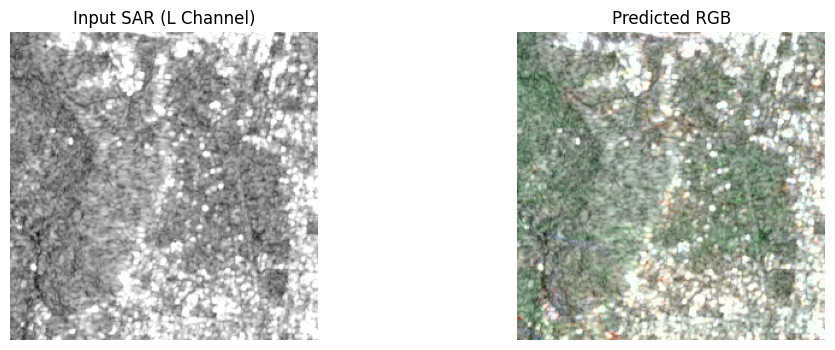

In [3]:
import torch
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import rgb2lab
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# --- Set the SAR image path here ---
sar_image_path = r".\dataset\sar\ROIs1970_fall_s1_13_p359.png" # Change to your image

# --- Find matching optical image ---
def base_name(fname):
    return fname.replace('_s1_', '_').replace('_s2_', '_')

sar_dir = os.path.join(DATASET_PATH, 'Sar')
optical_dir = os.path.join(DATASET_PATH, 'Optical')
optical_image_name = base_name(os.path.basename(sar_image_path)).replace('_', '_s2_', 1)
optical_image_path = os.path.join(optical_dir, optical_image_name)
if not os.path.exists(optical_image_path):
    # Try to find by base name
    for f in os.listdir(optical_dir):
        if base_name(f) == base_name(os.path.basename(sar_image_path)):
            optical_image_path = os.path.join(optical_dir, f)
            break
    else:
        raise FileNotFoundError(f"No matching optical image found for {sar_image_path}")

# --- Load images ---
sar_img = np.array(Image.open(sar_image_path).convert("L"))
optical_img = np.array(Image.open(optical_image_path).convert("RGB"))

# --- Resize/crop if needed ---
IMAGE_SIZE = 256
h, w = sar_img.shape
th, tw = IMAGE_SIZE, IMAGE_SIZE
if w > tw or h > th:
    x1 = np.random.randint(0, w - tw + 1)
    y1 = np.random.randint(0, h - th + 1)
    sar_img = sar_img[y1:y1+th, x1:x1+tw]
    optical_img = optical_img[y1:y1+th, x1:x1+tw, :]

# --- To tensor and Lab ---
import torchvision.transforms as T
sar_tensor = T.ToTensor()(sar_img.copy())
optical_lab = rgb2lab(optical_img).astype(np.float32)
optical_lab_t = T.ToTensor()(optical_lab)
L = sar_tensor
ab = optical_lab_t[[1, 2], :, :]
L_norm = (L * 2) - 1
ab_norm = (ab / 128.0)

# --- Load generator ---
checkpoint_path = os.path.join(CHECKPOINT_DIR, "last.pth")
checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
generator = GeneratorUNet().to(DEVICE)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

# --- Predict ---
sar_l_norm = L_norm.unsqueeze(0).to(DEVICE)
real_ab_norm = ab_norm.unsqueeze(0).to(DEVICE)
sar_l_orig = L.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    fake_ab_norm = generator(sar_l_norm)

# --- Convert to RGB ---
sar_l_recons_norm = (sar_l_orig * 2) - 1
pred_rgb = lab_to_rgb(sar_l_recons_norm, fake_ab_norm)[0]
gt_rgb = lab_to_rgb(sar_l_recons_norm, real_ab_norm)[0]

# --- Print PSNR and SSIM ---
psnr_value = psnr(gt_rgb, pred_rgb, data_range=255)
ssim_value = ssim(gt_rgb, pred_rgb, channel_axis=-1, data_range=255)
print(f"PSNR: {psnr_value:.4f}")
print(f"SSIM: {ssim_value:.4f}")

# --- Plot results ---
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(sar_img, cmap='gray')
plt.title("Input SAR (L Channel)")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(pred_rgb)
plt.title("Predicted RGB")
plt.axis('off')
plt.show()